In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gwpy.plot import Plot
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.waveform.generator import (FDomainDetFrameGenerator,FDomainCBCGenerator)
from pycbc.psd import EinsteinTelescopeP1600143
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
import generation_signal


### Génération du signal
Paramètre du signal initial que l'on génère :

In [2]:
seglen = 4
sample_rate = 2048
fmin = 20.
# Paramètres d'un signal de CBC (16 en tout)
cbc_params = {
            # Paramètres intrinsèques à la source
            'mass1': 38.6,
            'mass2': 29.3,
            'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0., 'spin2z': 0.,
            'eccentricity': 0,
            # Paramètres extrinsèques
            'ra': 1.37, 'dec': -1.26, 'distance': 1000,
            'polarization': 2.76, 'inclination': 0,
            'tc': 3.1 , 'coa_phase': 0}

approximant='IMRPhenomD'

para_reels = np.array([cbc_params['tc'],cbc_params['mass1'], cbc_params['mass2'],cbc_params['distance'],
                       cbc_params['ra'], cbc_params['dec'],cbc_params['polarization'],
                       cbc_params['inclination'],cbc_params['spin1z'],cbc_params['spin2z']])

signal = generation_signal.Signal_GW(seglen,sample_rate,fmin,cbc_params,approximant)

Génération selon les appareils de ET :

In [3]:
signalGW_ET = signal.signal_ET()
print(signalGW_ET)

{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f4b89b89fd0>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f4adf1d6f10>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f4ade6bd3a0>}


Génération selon LIGO (H1,L1) :

In [23]:
signalGW_LIGO = signal.signal_LIGO()
print(signalGW_LIGO)

{'H1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7ff76b3616d0>, 'L1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7ff76b361b50>}


### (CHOIX1) Signal sans buit

In [24]:
model_normal, signal_normal = signal.signal_simple(signalGW_ET)

### (CHOIX2) Signal avec bruit

In [4]:
model_noise, signal_noise = signal.signal_noise(signalGW_ET)

In [5]:
#model_noise=model_normal
model_noise.update(**cbc_params)
print('Log likelihood: {:.2f}'.format(model_noise.loglikelihood))
print('Log likelihood noise: {:.2f}'.format(model_noise.lognl))
print('Log likelihood ratio: {:.2f}'.format(model_noise.loglr))

Log likelihood: -12291.46
Log likelihood noise: -70965.28
Log likelihood ratio: 58673.81


In [6]:
snr_E1_sq = model_noise.det_optimal_snrsq('E1')
snr_E2_sq = model_noise.det_optimal_snrsq('E2')
snr_E3_sq = model_noise.det_optimal_snrsq('E3')

log_noise_likelihood_from_SNR = -0.5 * (snr_E1_sq + snr_E2_sq + snr_E3_sq)

print('SNR E1: {:.2f}'.format(snr_E1_sq**0.5))
print('SNR E2: {:.2f}'.format(snr_E2_sq**0.5))
print('SNR E3: {:.2f}'.format(snr_E3_sq**0.5))

print('Expected log likelihood noise: {:.2f}'.format(log_noise_likelihood_from_SNR))

SNR E1: 197.75
SNR E2: 217.63
SNR E3: 175.72
Expected log likelihood noise: -58673.81


### Minimisation en utilisant un DataFrame : minimums LOCAUX

Fonction scipy.optimize.minimize, charger les données depuis un fichier csv :

In [28]:
nom_fichier = "params_dataFrame_file_chirp_noise.txt"

params_dataFrame = pd.read_csv("data_files/" + nom_fichier)
para_opti = params_dataFrame.loc[params_dataFrame['mloglik'].idxmin()]

### Minimisation en utilisant un DataFrame : minimums GLOBAUX

On utilise cette fois la fonction scipy.optimize.basinhopping, charger les données depuis un fichier csv :

In [7]:
nom_fichier = 'params_glob_dataFrame_file_chirp.txt'

params_dataFrame_glob = pd.read_csv("data_files/" + nom_fichier)
para_opti = params_dataFrame_glob.loc[params_dataFrame_glob['mloglik'].idxmin()]

### Comparaison des signaux.

Conversion du signal réel dans le domaine temporel.

In [8]:
TSE1_reel = signal_noise['E1'].to_timeseries()
TSE2_reel = signal_noise['E2'].to_timeseries()
TSE3_reel = signal_noise['E3'].to_timeseries()

Génération et conversion en temporel d'un signal généré à partir des paramètres optimaux de minimisation.

/tmp/ipykernel_2238006/1041920686.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'mass1': para_opti[1],
/tmp/ipykernel_2238006/1041920686.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'mass2': para_opti[2],
/tmp/ipykernel_2238006/1041920686.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': para_opti[8], 'spin2z': para_opti[9],
/tmp/ipykernel_2238006/104

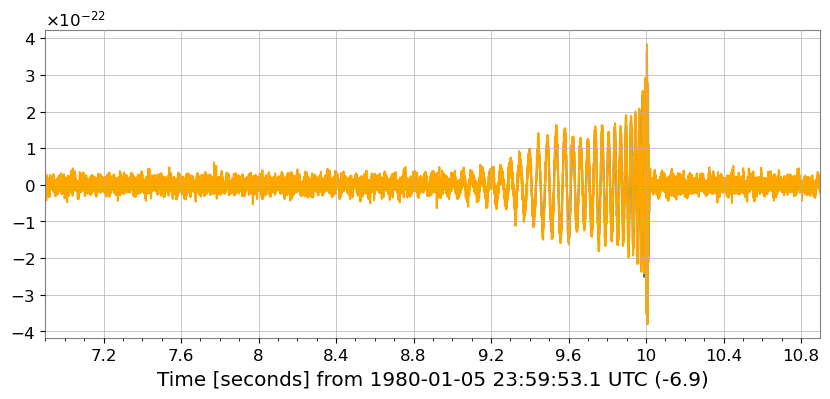

In [77]:
# Paramètres d'un signal de CBC (16 en tout)
cbc_params_opti = {
              # Paramètres intrinsèques à la source
              'mass1': para_opti[1],
              'mass2': para_opti[2],
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': para_opti[8], 'spin2z': para_opti[9],
              'eccentricity': 0,
              # Paramètres extrinsèques
              'ra': para_opti[4], 'dec': para_opti[5], 'distance': para_opti[3],
              'polarization': para_opti[6], 'inclination': para_opti[7],
              'tc': para_opti[0] , 'coa_phase': 0}

signal_opti = generation_signal.Signal_GW(seglen,sample_rate,fmin,cbc_params_opti,approximant)
signalGW_ET_opti = signal.signal_ET()

TSE1_opti = signalGW_ET_opti['E1'].to_timeseries()
TSE2_opti = signalGW_ET_opti['E2'].to_timeseries()
TSE3_opti = signalGW_ET_opti['E3'].to_timeseries()

TSE1_opti_time = signalGW_ET_opti['E1'].to_timeseries()
# t_end = TSE1_opti_time.get_sample_times()[-1]
# TSE1_opti_time = TSE1_opti_time.cyclic_time_shift(t_end - signal.tc)
# plt.plot(TSE1_opti_time.get_sample_times(),TSE1_opti_time)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(TSE1_opti_time.get_sample_times(),TSE1_opti_time)
ax.set_xscale('seconds', epoch=(signal.tc-10))
ax.plot(TSE1_reel.get_sample_times(),TSE1_reel, label='E1', color='orange')

/tmp/ipykernel_2238006/2424473191.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.text(0.6, 0.8, r'Params_opti : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(round(para_opti[1],2),
/tmp/ipykernel_2238006/2424473191.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  round(para_opti[2],2), round(para_opti[3],2), round(para_opti[4],2), round(para_opti[5],2),round(para_opti[6],2), round(para_opti[7],2),round(para_opti[8],2),
/tmp/ipykernel_2238006/2424473191.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.

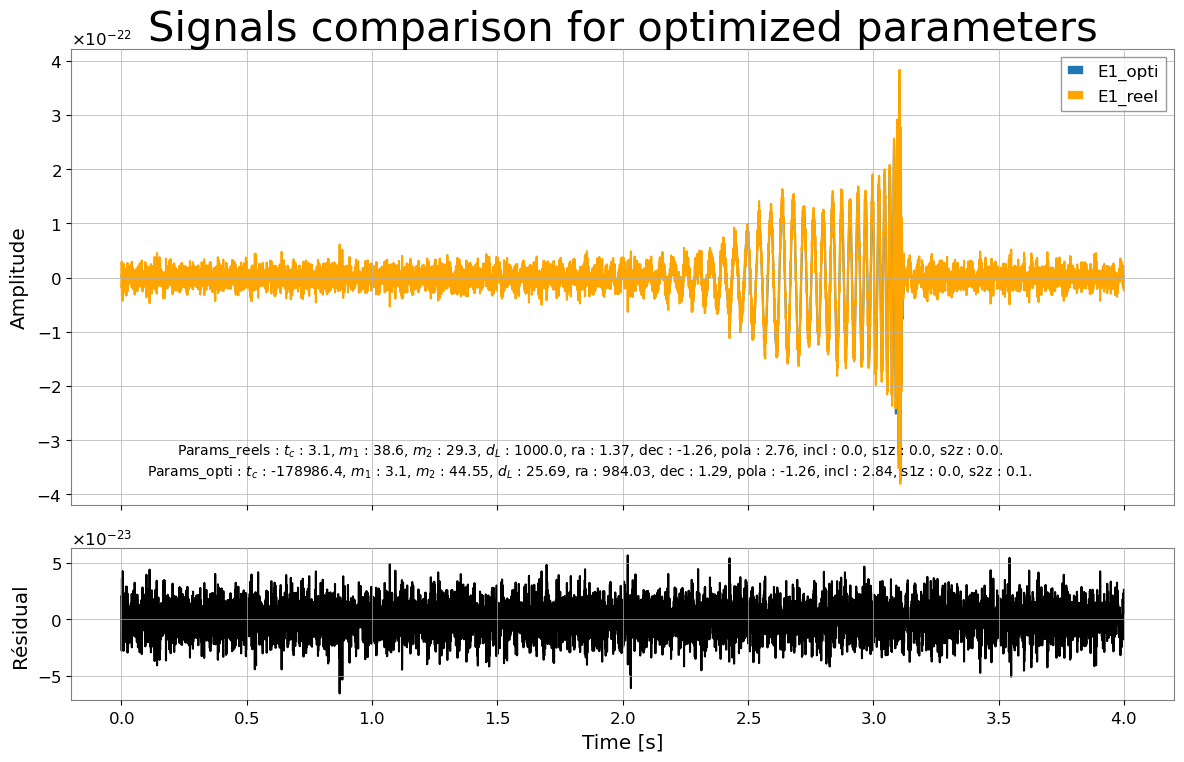

In [95]:
# Calcul de la différence
residual = TSE1_opti - TSE1_reel


# Création des subplots : 2 lignes, 1 colonne, partagent l'axe X
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Tracer les deux signaux dans le premier axe
ax1.plot(TSE1_opti_time.get_sample_times(),TSE1_opti_time,label='E1_opti')
ax1.plot(TSE1_reel.get_sample_times(),TSE1_reel, color='orange',label='E1_reel')
ax1.set_title('Signals comparison for optimized parameters', fontsize = 30)
ax1.set_ylabel('Amplitude')
ax1.text(0.6, 0.8, r'Params_opti : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(round(para_opti[1],2),
     round(para_opti[2],2), round(para_opti[3],2), round(para_opti[4],2), round(para_opti[5],2),round(para_opti[6],2), round(para_opti[7],2),round(para_opti[8],2),
     round(para_opti[9],2),round(para_opti[10],2)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax1.text(0.6, 0.87, r'Params_reels : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(para_reels[0],
     para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5], para_reels[6], para_reels[7], para_reels[8], para_reels[9]), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax1.legend()

# Tracer la différence dans le second axe
ax2.plot(residual.get_sample_times(), residual, color='black')
ax2.set_ylabel('Résidual')
ax2.set_xlabel('Time [s]')


plt.tight_layout()
plt.savefig("Full_loc_minim_L1_Comparaison_signal")